In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm
import scipy as sp
import itertools
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
MyColors = ["#0078D7", "#E74856", "#FFB900", "#10893E", "#B146C2",
"#00B7C3", "#E3008C", "#FF8C00", "#00CC6A", "#6B69D6",
"#0099BC", "#C30052", "#F7630C", "#00B294", "#8764B8"]
sns.set_palette(MyColors)

In [9]:
# Read discount factor data
df_init = pd.read_csv(r"C:\Users\yahsk\Desktop\Q2\Fixed income markets\ALL HW AND SOLUTIONS except 8\Homework_export 7\Homework 7\pfilea.csv", header=None)[0]
df_init.index = np.arange(0.5, 15+0.5, 0.5)
df_init = df_init[:10]

In [12]:
# Read volatility data
vol = pd.read_csv(r"C:\Users\yahsk\Desktop\Q2\Fixed income markets\ALL HW AND SOLUTIONS except 8\Homework_export 7\Homework 7\voldat.csv", header=None)[0]
vol.index = np.arange(1, 15+0.5, 0.5)
vol[0.5] = 0
vol = vol.sort_index()[:10]

In [13]:
# Read cholesky matrix
mat_chol = pd.read_excel(r"C:\Users\yahsk\Desktop\Q2\Fixed income markets\ALL HW AND SOLUTIONS except 8\Homework_export 7\Homework 7\Homework_7_Data.xlsx", sheet_name=1, header=None).values


In [14]:
# Function to compute short rate based on string model
def string(df, vol, mat_chol, seed):
    # Generate dz
    np.random.seed(seed)
    dz = pd.DataFrame(mat_chol @ np.random.normal(size=[20, 20]),
        index=np.arange(0.5, 10+0.5, 0.5),
        columns=np.arange(0.5, 10+0.5, 0.5))
    # Repeatedly compute short rate & DF curve t=0.5 to 9.5
    # Note: index: maturity, columns: time
    B = pd.DataFrame(None,
        index=np.arange(0.5, 10+0.5, 0.5),
        columns=np.arange(0, 10+0.5, 0.5))
    r_save = pd.Series(index=np.arange(0, 9.5+0.5, 0.5))
    # Repeat process
    B[0] = df
    vol_t = vol.copy()
    for t in np.arange(0.5, 10+0.5, 0.5):
        r = (1/B[t-0.5][t]-1)*2
        B[t] = B[t-0.5]+r*B[t-0.5]/2 + vol_t*B[t-0.5]*dz[t]
        vol_t = vol_t.shift()
        r_save[t-0.5] = r
    return r_save

In [15]:
# Monte Carlo simulation: String model
r_sim = pd.DataFrame({n: string(df_init, vol, mat_chol, n)
for n in range(0, 10000)})

In [16]:
#Compute discount factor path
df_sim = (1/(1+r_sim/2)).cumprod()
df_sim.index = np.arange(0.5, 10+0.5, 0.5)

In [17]:
r_sim.T[0:6].T

,0,1,2,3,4,5
0.0,0.056605,0.056605,0.056605,0.056605,0.056605,0.056605
0.5,-0.159872,-0.183652,0.182708,-0.205862,0.088557,0.012449
1.0,0.017215,0.155968,0.086947,-0.029021,0.010023,0.193878
1.5,-0.031646,0.094839,0.717376,-0.140293,0.157849,-0.274650
2.0,-0.277459,0.194031,-0.115602,0.534981,0.310749,-0.084222
2.5,-0.400526,-0.164426,0.604425,0.184900,-0.043334,-0.128193
3.0,0.117645,0.576069,0.283137,0.372412,0.245961,-0.281151
3.5,-0.177417,-0.235587,-0.009296,0.101913,0.386836,0.029237
4.0,-0.135820,0.167433,0.462785,0.434517,0.304456,0.176883
4.5,0.568107,-0.083666,0.021297,0.402359,0.050822,0.529535


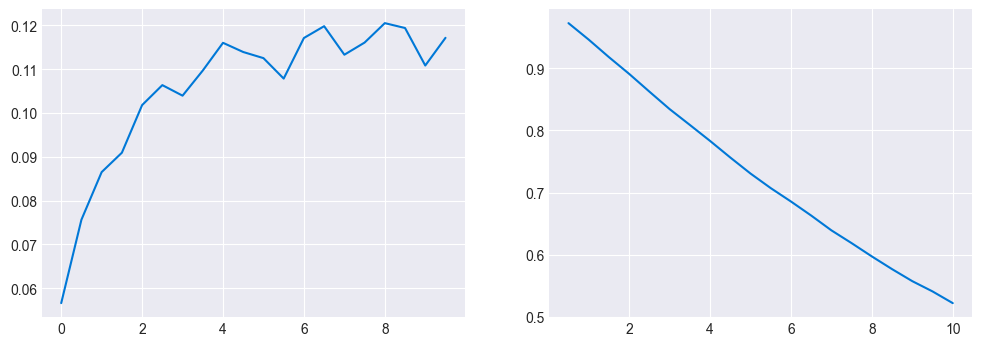

In [18]:
# Plot average short rate curve and DF curve
fig, ax = plt.subplots(1, 2, figsize=(6*2, 4))
r_sim.T.mean().plot(ax=ax[0])
df_sim.T.mean().plot(ax=ax[1]);

In [19]:
# Compute forward par rate based on the simulated path
fwd_par_sim = pd.DataFrame({
m: 2*(df_sim.loc[5,:]-df_sim.loc[5+m,:])/df_sim[(5+0.5):(5+m)].sum()
for m in range(1, 5+1)
})

In [20]:
# Compute the expected value of forward par rate
fwd_par = fwd_par_sim.mean()
fwd_par

1    0.101279
2    0.098716
3    0.096025
4    0.094867
5    0.092854
dtype: float64

In [21]:
# Reference: Compute the forward par rate based on the initial curve
fwd_par_init = pd.Series({
m: 2*(df_init[5]-df_init[5+m])/df_init[(5+0.5):(5+m)].sum()
for m in range(1, 5+1)
})
fwd_par_init

1    0.068886
2    0.069452
3    0.069903
4    0.070248
5    0.070489
dtype: float64

In [22]:
# Compute par rate based on the simulated path
par_sim = pd.DataFrame({
m: 2*(1-df_sim.loc[m,:])/df_sim[0.5:m].sum()
for m in [2,3,5,10]
})

In [23]:
par = par_sim.mean()
par

2     0.068331
3     0.074518
5     0.080044
10    0.082530
dtype: float64

In [24]:
def calc_cap(K, r_sim, df_sim):
    cf_sim = (r_sim-K)*0.5
    cf_sim = cf_sim.mask(cf_sim<0,0)
    cf_sim.index = df_sim.index
    pv = (cf_sim*df_sim).sum().mean()
    return pv

In [25]:
pv_cap = par.apply(lambda x: calc_cap(x, r_sim, df_sim))
pv_cap

2     0.726934
3     0.707610
5     0.690687
10    0.683179
dtype: float64

In [26]:
def calc_reset_cap(m, r_sim, df_sim):
    cf = 0.5*r_sim.diff()
    cf.index = df_sim.index
    pv = (cf.mask(cf<0,0)*df_sim).loc[:m].sum().mean()
    return pv

In [27]:
calc_reset_cap(5, r_sim, df_sim)

0.4483009965197644

In [28]:
m = 5
cms_sim = pd.DataFrame({
    t: 2*(df_sim.loc[t,:]-df_sim.loc[t+m,:])/df_sim[(t+0.5):(t+m)].sum()
    for t in np.arange(0.5, 5+0.5, 0.5)}).T

In [29]:
cms_sim.loc[:,0:4]

,0,1,2,3,4
0.5,-0.055701,0.067464,0.232266,0.123540,0.162603
1.0,-0.020736,0.052849,0.206981,0.184982,0.141428
1.5,-0.024471,0.109123,0.191092,0.144382,0.149492
2.0,-0.008744,0.097955,0.154721,0.164366,0.111103
2.5,0.001395,0.081903,0.221743,0.008159,0.033618
3.0,0.076974,0.088572,0.178841,-0.014898,0.014462
3.5,0.081370,0.053464,0.132715,-0.019683,-0.041748
4.0,0.121047,0.089100,0.124586,-0.002599,-0.072818
4.5,0.166018,0.097381,0.040279,-0.005713,-0.134135
5.0,0.143704,0.134150,-0.034018,0.001070,-0.113246


In [30]:
cf_sim = cms_sim-0.05
cf_sim = 0.5*cf_sim.mask(cf_sim<0,0)
pv = (cf_sim*df_sim[:5]).sum().mean()
pv

0.2835113658718464